# Predicting the Next Top Five Prize Money Owners' Name

## Team member : 
- Haoyu You 34735811
- Xiaomeng Zhou 67409466
- Natalia He 94652260
- Ruodan Deng 29414646

In [1]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Introduction:

Tennis players' rankings and earnings are particularly important in determining their market worth and success in the world of professional sports. Player ranking and prize money have a largely positive link. Those with higher rankings often take home more substantial prize money than those with lower rankings. Although a high rank might enhance the probability of receiving more prize money, it is not the only factor.

- How can tennis players utilize their age and current ranks for higher prize money?


In order to predict the future top five prize money owners in the sport of tennis, we have opted to use a few players' names, ages, current ranks, and prize money. The name of the player can help us determine the identity of the player. While current rank shows a player's current performance level, age might reveal information about a player's background and probable longevity in the sport. Prize money is a measure of a player's financial success and competitiveness in tournaments.


## Preliminary exploratory data analysis:

1. Demonstrate that the dataset can be read from the web into R 

In [2]:
player <- read_csv("player_stats.csv")
player

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


2. Clean and wrangle your data into a tidy format


In [3]:
player_data <- player |>
               separate(col = `Age`, into = c("age","birth_date"), sep = "\\(") |>
               mutate(age = as.integer(age)) |>
               mutate(birth_date = str_remove(birth_date, "\\)")) |>
               separate(col = `Current Rank`, into = c("current_rank","current_score"), sep = "\\(") |>
               mutate(current_rank = as.integer(current_rank)) |>
               mutate(current_score = as.integer(str_remove(current_score, "\\)"))) |>
               mutate(prize_money = str_remove_all(`Prize Money`, "[A-Za-z$, ]")) |>
               mutate(prize_money = as.integer(prize_money)) |>
               mutate(name = as.character(Name)) |>
               select(name, age, current_rank, prize_money)|>
               na.omit()
player_data

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


name,age,current_rank,prize_money
<chr>,<int>,<int>,<int>
Jack Draper,18,326,59040
Lukas Lacko,32,178,3261567
Duck Hee Lee,21,236,374093
⋮,⋮,⋮,⋮
Artem Dubrivnyy,20,397,40724
Dan Added,20,382,57943
Aziz Dougaz,22,451,61984


3. Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

In [4]:
player_split <- player_data |>
                initial_split(prop = 0.75, strata = prize_money)
player_training <- training(player_split)
player_testing <- testing(player_split)

player_training

name,age,current_rank,prize_money
<chr>,<int>,<int>,<int>
Tung Lin Wu,21,232,59123
Sanjar Fayziev,25,417,122734
Andrea Pellegrino,22,339,87942
⋮,⋮,⋮,⋮
Marcos Baghdatis,34,179,8918917
Ruben Bemelmans,32,260,2013015
Yoshihito Nishioka,24,71,1703096


4. Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [5]:
options(repr.plot.width = 8, repr.plot.height = 7)

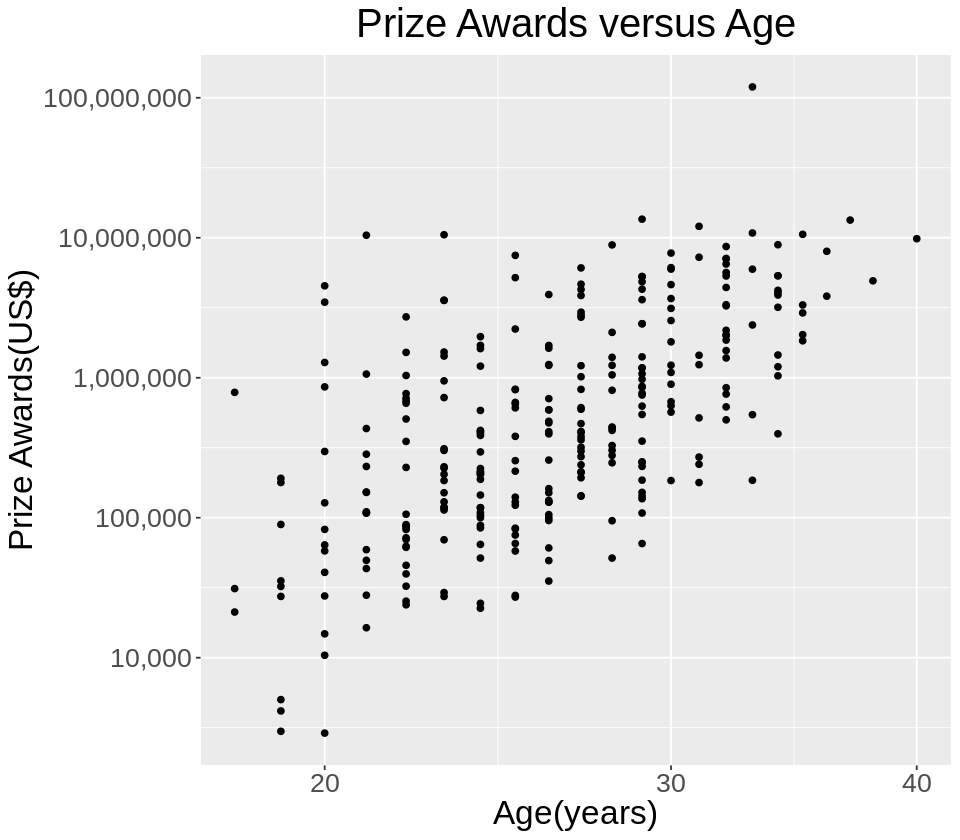

In [6]:
age_plot <- player_training |>
            ggplot(aes(x = age, y = prize_money)) +
            geom_point() +
            labs(x = "Age(years)", y = "Prize Awards(US$)") +
            theme(text = element_text(size = 20),
                  plot.title = element_text(hjust = 0.5)) +
            scale_x_log10(labels = comma) +
            scale_y_log10(labels = comma) +
            ggtitle("Prize Awards versus Age")

age_plot

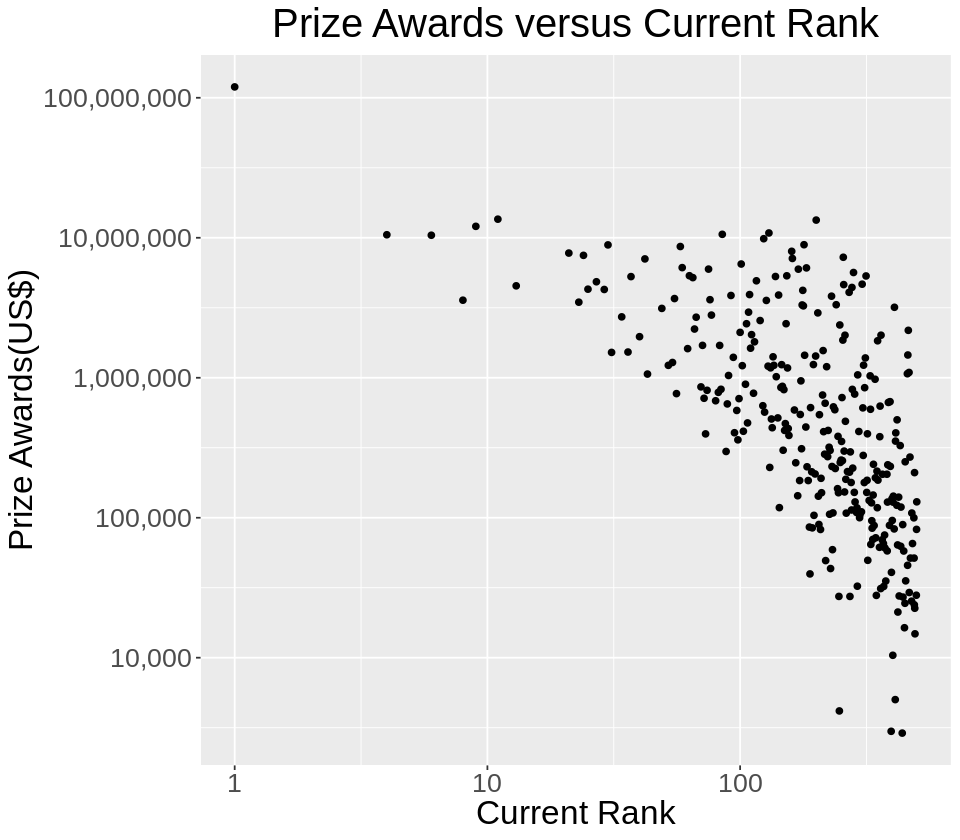

In [7]:
current_rank_plot <- player_training |>
                    ggplot(aes(x = current_rank, y = prize_money)) +
                    geom_point() +
                    labs(x = "Current Rank", y = "Prize Awards(US$)") +
                    theme(text = element_text(size = 20),
                         plot.title = element_text(hjust = 0.5)) +
                    scale_x_log10(labels = comma) +
                    scale_y_log10(labels = comma) +
                    ggtitle("Prize Awards versus Current Rank")

current_rank_plot

## Method

We first need to determine the k-value and find the most appropriate k-value using cross- validation and RMSE. 

To find the minimum RMSE complete the model with the nearest_neighbor() equation, where neighbors should be equal to tune(). 

The recipe() equation is used to complete the recipe, followed by the vfold_cv() equation to determine the training data into 5 folds, with strata equal to the prize money. 

The workflow() equation is used to combine the recipe and the model. After completing the preparation work, the tune_grid() and collect_metrics() equations are used to complete the k-value prediction, and the filter(), arrange() and slice() are used to find the k-value with the lowest  mean of RMSE. 

Next we will start predicting the prize money, using nearest_neighbor(), recipe(), workflow(), predict(), bind_cols() and metrics() functions to complete the prediction, and then rank the predicted results from largest to smallest, find the top five highest prize money and the corresponding current ranking, and use the filter() equation to find the corresponding names.

Finally, the relationship between age and prize money and the relationship between current ranking and prize money can be plotted using the ggplot() equation. 


## Expected outcomes and significance:


Through analyzing the relationships among player current ranks, ages and prize money, our objective is to preliminarily predict the top five players who have earned the highest prize money in the upcoming season. 

By conducting a preliminary analysis of the connection between these two variables and prize money, we can gain a deeper understanding of the factors that influence prize money evaluation. This understanding can serve as an available guide for players, helping them to strive for higher earnings in their respective fields.

Given the absence of complete individual player data, it is crucial to consider other variables that might influence the evaluation of prize money. Are there any additional factors apart from those mentioned that impact the assessment of earnings?
